In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from synthpop import MissingDataHandler, DataProcessor, CARTMethod
from synthpop.metrics import (
    MetricsReport,
    EfficacyMetrics,
    DisclosureProtection
)
import matplotlib.pyplot as plt
from helper_functions import *
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

### Load data and data preperation

In [2]:
admissions_df = pd.read_csv('../datasets/data/bar_pass_prediction.csv', index_col=False)
print(admissions_df.shape)
print(admissions_df.columns)
display(admissions_df.head())

(22407, 39)
Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')


,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


In [3]:
# description
print(admissions_df.shape)
print(admissions_df.isnull().sum())

(22407, 39)
decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr                      40
fulltime                     34
fam_inc                     289
age                          89
gender                        5
parttime                     34
male                          5
race1                        16
race2                        16
Dropout                       0
other                         0
asian                         0
black                         0
hisp                          0
pass_bar                    

In [4]:
# subset of data
df = admissions_df[['sex', 'race1', 'ugpa', 'bar']]

**UI text #1**

A subset of the [Law School Admission Bar*](https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage) dataset is used as a demo. Synthetic data will be generated for the following columns: 

[table]

The CART method is used to generate the synthetic data. CART generally produces higher quality synthetic datasets, but might not run on datasets with categorical variables with 20+ categories. Use Gaussian Copula in those cases.

*The original paper can be found [here](https://files.eric.ed.gov/fulltext/ED469370.pdf).

### 0. Preview of real data

In [5]:
# demo dataset
df.head()

,sex,race1,ugpa,bar
0,1.0,white,3.5,a Passed 1st time
1,1.0,white,3.5,a Passed 1st time
2,2.0,white,3.5,a Passed 1st time
3,2.0,white,3.5,a Passed 1st time
4,2.0,white,3.5,a Passed 1st time


In [6]:
# missing data
print(df.isnull().sum())

sex       5
race1    16
ugpa      0
bar       0
dtype: int64


In [7]:
# manually make sex categorical data
df['sex'] = df['sex'].replace({1: 'male', 2: 'female'})
df.head()

,sex,race1,ugpa,bar
0,male,white,3.5,a Passed 1st time
1,male,white,3.5,a Passed 1st time
2,female,white,3.5,a Passed 1st time
3,female,white,3.5,a Passed 1st time
4,female,white,3.5,a Passed 1st time


### 1. Data types detection

In [8]:
md_handler = MissingDataHandler()

# Check the data types
column_dtypes = md_handler.get_column_dtypes(df)
print("Column Data Types:", column_dtypes)

Column Data Types: {'sex': 'categorical', 'race1': 'categorical', 'ugpa': 'numerical', 'bar': 'categorical'}


**UI text #2**

If the detected data types are incorrect, please change this locally in the source dataset before attaching it to the app.

### 2. Missing data handler

In [9]:
# Detect missingness
missingness_dict = md_handler.detect_missingness(df)
print("Detected Missingness Type:", missingness_dict)

Detected Missingness Type: {'sex': 'MAR', 'race1': 'MAR'}


**UI text #3**

For Missing At Random (MAR) and Missing Not At Random (MNAR) data, we recommend to impute the missing data. For Missing Completely At Random (MCAR), we recommend to remove the missing data. See the info box for more information.

_info box:_

MCAR, MAR, and MNAR are terms used to describe different mechanisms of missing data:

1. **MCAR (Missing Completely At Random)**:
- The probability of data being missing is completely independent of both observed and unobserved data. 
- There is no systematic pattern to the missingness.
- Example: A survey respondent accidentally skips a question due to a printing error.
- Recommendation: remove missing data.

2. **MAR (Missing At Random)**:
- The probability of data being missing is related to the observed data but not the missing data itself.
- The missingness can be predicted by other variables in the dataset.
- Example: Students' test scores are missing, but the missingness is related to their attendance records.
- Recommendation: impute missing data.

3. **MNAR (Missing Not At Random)**:
- The probability of data being missing is related to the missing data itself. 
- There is a systematic pattern to the missingness that is related to the unobserved data.
- Example: Patients with more severe symptoms are less likely to report their symptoms, leading to missing data that is related to the severity of the symptoms.
- Recommendation: impute missing data.

In [10]:
df_imputed = md_handler.apply_imputation(df, missingness_dict)

print(df_imputed.isnull().sum())

sex      0
race1    0
ugpa     0
bar      0
dtype: int64


### 3. Pre-processing data

**UI text #4**

In the next step the data is pre-processed. The dataframe is transformed into numerical space. The following steps are performed:

1. Validates the input data;
2. Stores the original column order;
3. Encoding and scaling:
* Encodes categorical columns using LabelEncoder or OneHotEncoder;
* Scales numerical columns using StandardScaler;
* Converts boolean columns to integers.

In [11]:
# Instantiate the DataProcessor with the metadata
metadata = column_dtypes
processor = DataProcessor(metadata)

# Preprocess the data: transforms raw data into a numerical format
processed_data = processor.preprocess(df)
print("Processed Data:")
display(processed_data.head())

Processed Data:


,sex,race1,ugpa,bar
0,1,4,0.70422,0
1,1,4,0.70422,0
2,0,4,0.70422,0
3,0,4,0.70422,0
4,0,4,0.70422,0


### 4. Synthetic data generation: {CART/GC}

In [12]:
# Instantiate and fit the CART method
cart = CARTMethod(metadata, smoothing=True, proper=True, minibucket=5, random_state=42)
cart.fit(processed_data)

In [13]:
# For prediction, we might use the same data (or new preprocessed data)
synthetic_processed = cart.sample(5000)
print("Synthetic Processed Data (in numerical space):")
display(synthetic_processed.head())

Synthetic Processed Data (in numerical space):


,sex,race1,ugpa,bar
0,1,1,0.656076,0
1,1,4,0.851544,0
2,1,4,-0.586482,2
3,1,1,-1.153123,2
4,0,4,-1.226077,0


**UI text #5**

{n_synth_data} synthetic data points are generated using CART. 

The CART (Classification and Regression Trees) method generates synthetic data by learning patterns from real data through a decision tree that splits data into homogeneous groups based on feature values. It predicts averages for numerical data and assigns the most common category for categorical data, using these predictions to create new synthetic points. Then, the the synthetic data back to the original format (postprocessing).

### 5. Generated synthetic data

In [14]:
# Postprocess the synthetic data back to the original format
synthetic_data = processor.postprocess(synthetic_processed)
print("Synthetic Data in Original Format:")
display(synthetic_data.head())

Synthetic Data in Original Format:


,sex,race1,ugpa,bar
0,male,black,3.480547,a Passed 1st time
1,male,white,3.559528,a Passed 1st time
2,male,white,2.978475,c Failed
3,male,black,2.749516,c Failed
4,female,white,2.720038,a Passed 1st time


### 6. Evaluation of generated data

In [15]:
# combine original data and decoded synthetic data in dataframe
combined_data = pd.concat((df.assign(realOrSynthetic='real'), synthetic_data.assign(realOrSynthetic='synthetic')), keys=['real','synthetic'], names=['Data'])
combined_data

sex  race1      ugpa                bar realOrSynthetic
Data                                                                      
real      0       male  white  3.500000  a Passed 1st time            real
          1       male  white  3.500000  a Passed 1st time            real
          2     female  white  3.500000  a Passed 1st time            real
          3     female  white  3.500000  a Passed 1st time            real
          4     female  white  3.500000  a Passed 1st time            real
...                ...    ...       ...                ...             ...
synthetic 4995    male  white  3.475729  a Passed 1st time       synthetic
          4996    male   hisp  3.584729  a Passed 1st time       synthetic
          4997    male  black  3.937220  a Passed 1st time       synthetic
          4998    male  white  3.061568  a Passed 1st time       synthetic
          4999  female  white  3.368510  a Passed 1st time       synthetic

[27407 rows x 5 columns]

#### 6.1 Univariate distributions

**UI text #6**

{n_synth_data} synthetic data points are generated using CART. The figures below display the differences in value frequency for each variable. The synthetic data is of high quality when all bars are of equal height.

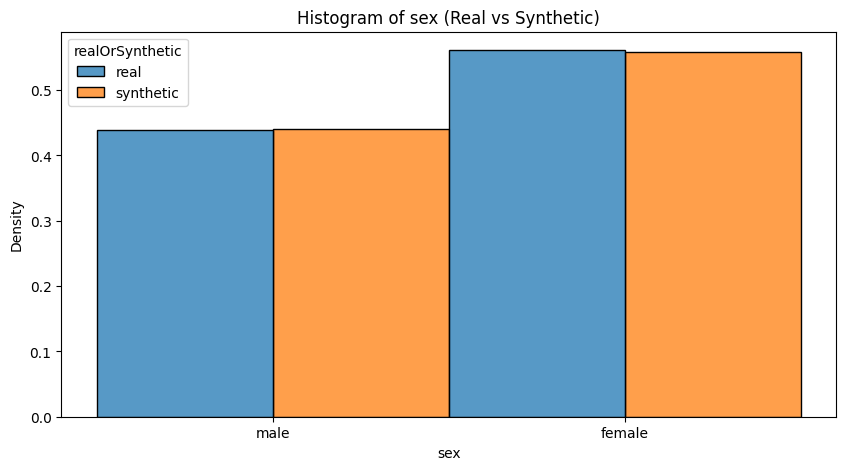

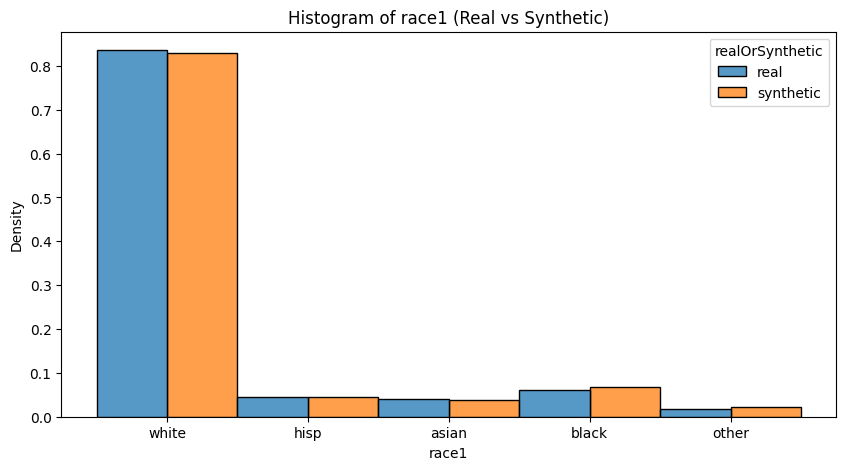

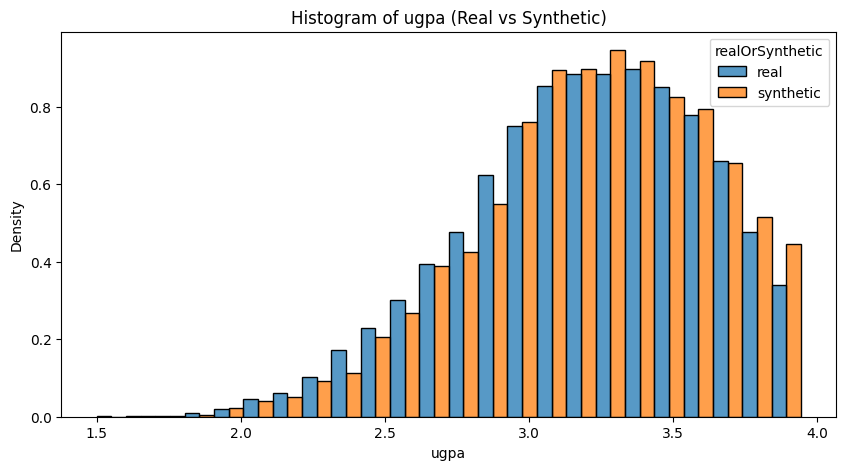

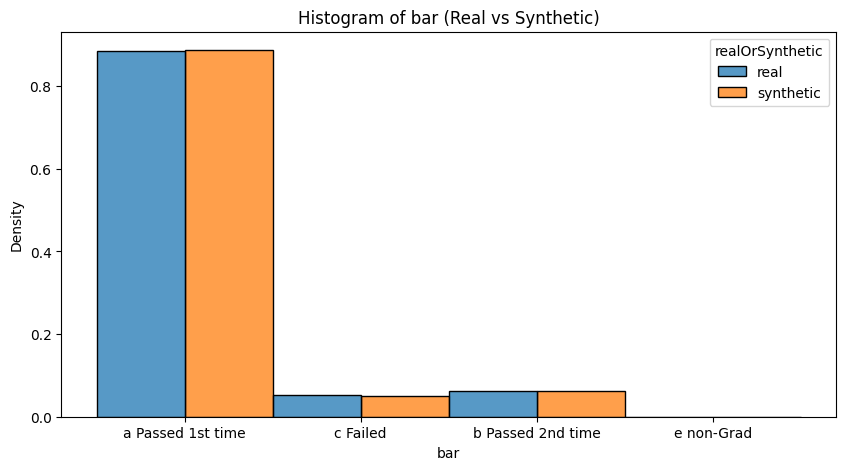

In [16]:
# Plot histograms for each column comparing real and synthetic data
for column in df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=combined_data, x=column, hue='realOrSynthetic', element='bars', stat='density', common_norm=False, multiple='dodge', binwidth=0.1)
    plt.title(f'Histogram of {column} (Real vs Synthetic)')
    plt.show()

#### 6.2 Diagnostic report

##### 6.2.1 Diagnostic report

**UI text #6**

The report computes the following diagnostic results for each column:
- For numerical (or datetime) columns:
    * *Missing value similarity:* Similarity in the proportion of missing values.
    * *Range coverage:* Proportion of the real data's range covered by the synthetic data.
    * *Boundary adherence:* Fraction of synthetic values within the real data's min/max.
    * *Kolmogorov–Smirnov (KS) complement:* Uses the two-sample Kolmogorov–Smirnov test to compare the distributions of the two continuous columns using the empirical CDF. It returns 1 minus the KS Test D statistic, which indicates the maximum distance between the expected CDF and the observed CDF values.
    * *Statistic similarity:* Similarity of mean, std, and median.
- For categorical (or boolean) columns:
    * *Missing value similarity:* Similarity in the proportion of missing values.
    * *Total variation (TV) complement:* Compute the complement of the total variation distance of two discrete columns.
    * *Category coverage:* Proportion of real categories found in synthetic data.
    * *Category adherence:* Fraction of synthetic values that are valid real categories.


💯 All values need to be close to 1.0 

In [17]:
# Instantiate and generate a diagnostic report
report = MetricsReport(df, synthetic_data, metadata)
report_df = report.generate_report()
print("=== Diagnostic Report ===")
display(report_df)

=== Diagnostic Report ===


,column,type,missing_value_similarity,range_coverage,boundary_adherence,ks_complement,tv_complement,statistic_similarity,category_coverage,category_adherence
0,sex,categorical,0.999223,N/A,N/A,N/A,0.99738,N/A,1.0,1.0
1,race1,categorical,0.999914,N/A,N/A,N/A,0.988729,N/A,1.0,1.0
2,ugpa,numerical,1.000000,0.916638,0.9794,0.948035,N/A,0.992807,N/A,N/A
3,bar,categorical,1.000000,N/A,N/A,N/A,0.998193,N/A,0.75,1.0


##### 6.2.2 Correlation matrix

**UI text #7**

The matrix below illustrates the differences in pairwise correlations between variables in the original and synthetic data. Green cells signify that the pairwise correlation was accurately captured, with 0 representing the best possible score. Red cells indicate poor capture of the pairwise correlation.

In [18]:
metadata

{'sex': 'categorical',
 'race1': 'categorical',
 'ugpa': 'numerical',
 'bar': 'categorical'}

In [19]:
# Convert categorical variables to numerical values
df_encoded = df.copy()
df_encoded['sex'] = df_encoded['sex'].astype('category').cat.codes
df_encoded['race1'] = df_encoded['race1'].astype('category').cat.codes
df_encoded['bar'] = df_encoded['bar'].astype('category').cat.codes

synth_df_encoded = synthetic_data.copy()
synth_df_encoded['sex'] = synth_df_encoded['sex'].astype('category').cat.codes
synth_df_encoded['race1'] = synth_df_encoded['race1'].astype('category').cat.codes
synth_df_encoded['bar'] = synth_df_encoded['bar'].astype('category').cat.codes

Text(0.5, 1.05, 'Absolute difference in correlation matrix, i.e., |real data - synthetic data|')

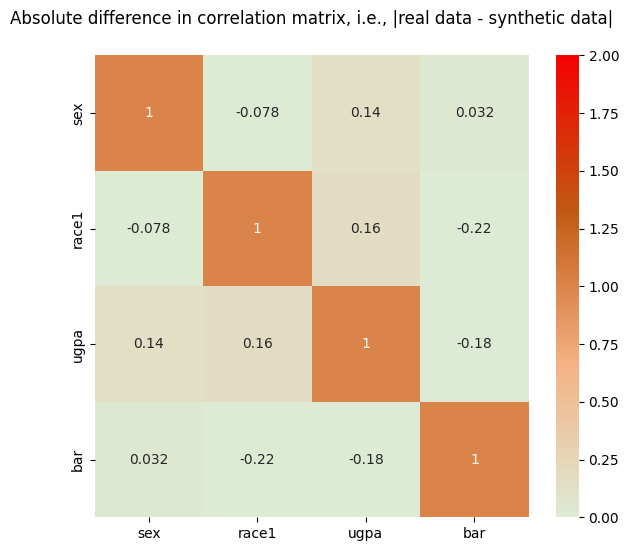

In [20]:
# Plot difference in correlation matrix between attached data and synthetic data
plt.figure(figsize=(7, 6))

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#ddebd5', '#f4b183', '#c15811', '#f50101'])

# Plot correlation matrix for real_data
sns.heatmap(df_encoded.corr(), annot=True, cmap=cmap, vmin=0, vmax=2)
plt.title('Absolute difference in correlation matrix, i.e., |real data - synthetic data|', y=1.05)

Text(0.5, 1.05, 'Absolute difference in correlation matrix, i.e., |real data - synthetic data|')

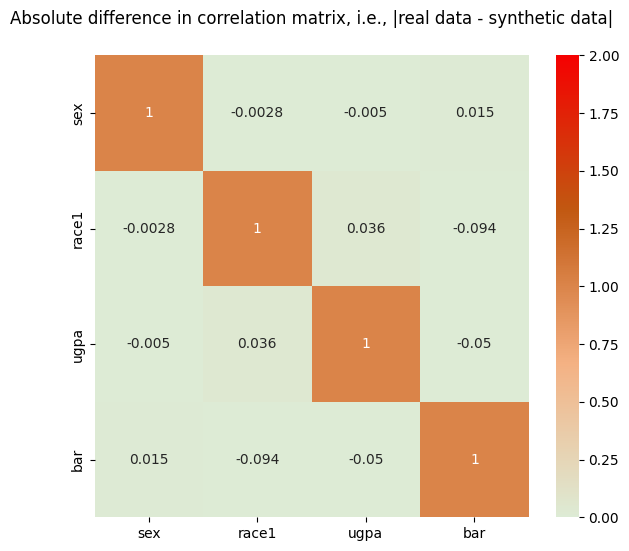

In [21]:
# Plot difference in correlation matrix between attached data and synthetic data
plt.figure(figsize=(7, 6))

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#ddebd5', '#f4b183', '#c15811', '#f50101'])

# Plot correlation matrix for real_data
sns.heatmap(synth_df_encoded.corr(), annot=True, cmap=cmap, vmin=0, vmax=2)
plt.title('Absolute difference in correlation matrix, i.e., |real data - synthetic data|', y=1.05)

##### 6.2.3 Efficacy Metrics (regression and classification)

In [23]:
reg_efficacy = EfficacyMetrics(task='regression', target_column="bar")
reg_metrics = reg_efficacy.evaluate(df, synthetic_data)
print("=== Regression Efficacy Metrics ===")
print(reg_metrics)

ValueError: could not convert string to float: 'male'

In [24]:
clf_efficacy = EfficacyMetrics(task='classification', target_column="bar")
clf_metrics = clf_efficacy.evaluate(df, synthetic_data)
print("\n=== Classification Efficacy Metrics ===")
print(clf_metrics)


=== Classification Efficacy Metrics ===
{'accuracy': 0.8021600392734414, 'f1_score': 0.8018803804777332}


##### 6.2.4 Privacy Metrics

In [25]:
dp = DisclosureProtection(df, synthetic_data)
dp_score = dp.score()
dp_report = dp.report()

print("\n=== Disclosure Protection ===")
print(f"Score: {dp_score:.3f}")
print("Detailed Report:", dp_report)


=== Disclosure Protection ===
Score: 1.000
Detailed Report: {'threshold': 0.0, 'risk_rate': 0.0, 'disclosure_protection_score': 1.0}


#### 6.3 Bivariate distributions

**UI text #8**

The figures below display the differences in value frequency for a combination of variables. For comparing two categorical variables, bar charts are plotted. For comparing a numerical and a categorical variables, a so called [violin plot](https://en.wikipedia.org/wiki/Violin_plot) is shown. For comparing two numercial variables, a [LOESS plot](https://en.wikipedia.org/wiki/Local_regression) is created. For all plots holds: the synthetic data is of high quality when the shape of the distributions in the synthetic data equal the distributions in the real data.

<Figure size 800x500 with 0 Axes>

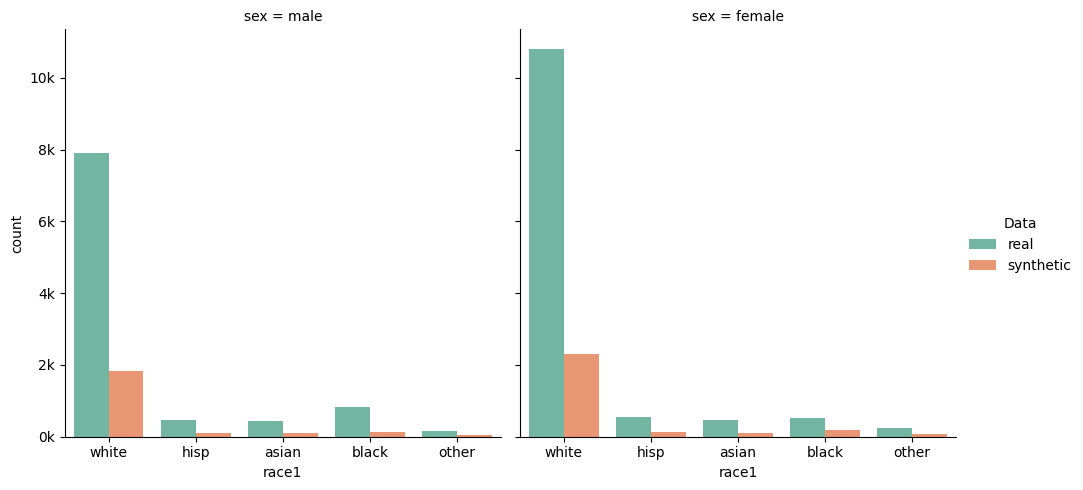

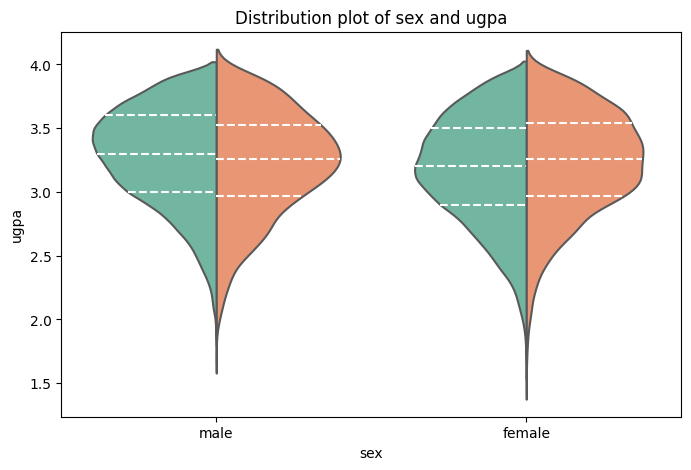

<Figure size 800x500 with 0 Axes>

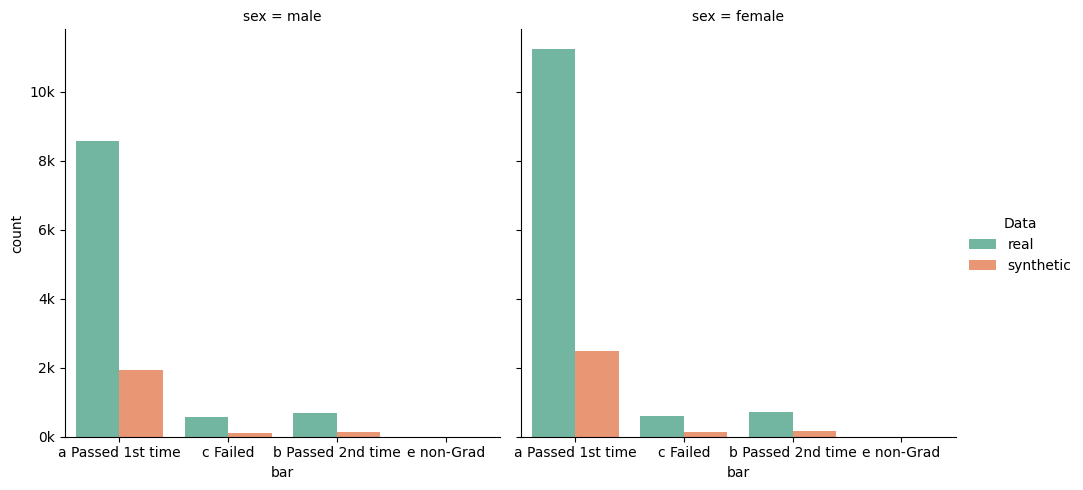

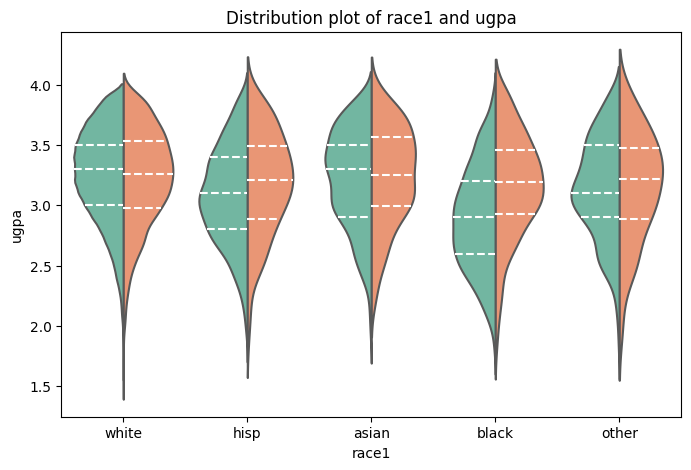

<Figure size 800x500 with 0 Axes>

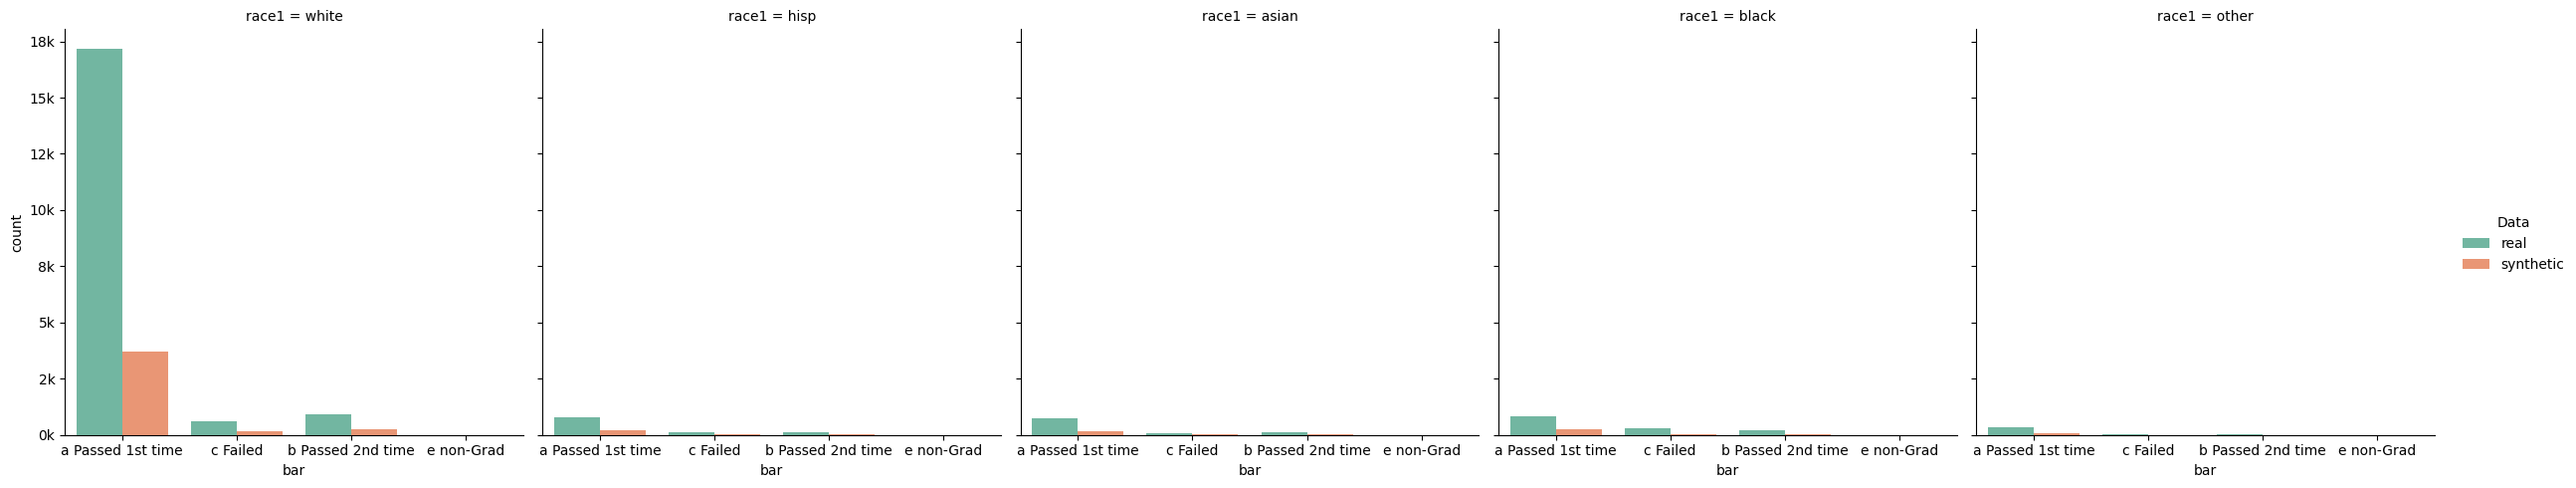

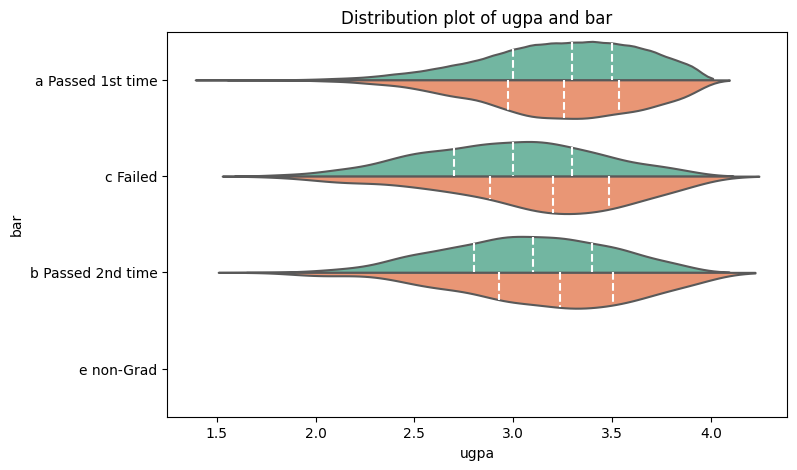

In [27]:
bivariate_plot(df, combined_data, column_dtypes, Comparison=True)

### 7. More information

**UI text #7**

Do you want to learn more about synthetic data?
- Source code of this tool:
    - [python-synthpop](https://github.com/NGO-Algorithm-Audit/python-synthpop)
    - [local-first web app](https://github.com/NGO-Algorithm-Audit/local-first-web-tool/tree/main) 
- [Synthetic Data: what, why and how?](https://royalsociety.org/-/media/policy/projects/privacy-enhancing-technologies/Synthetic_Data_Survey-24.pdf)
- [Knowledge Network Synthetic Data](https://online.rijksinnovatiecommunity.nl/groups/399-kennisnetwerk-synthetischedata/welcome) (for Dutch public organizations)
- [Synthetic data portal of Dutch Executive Agency for Education](https://duo.nl/open_onderwijsdata/footer/synthetische-data.jsp) (DUO)
- [CART: synthpop resources](https://synthpop.org.uk/resources.html)
- [Gaussian Copula - Synthetic Data Vault](https://docs.sdv.dev/sdv)
